# PLASMA -- Equation Mappings Demo

In this notebook we're mapping PREDICT data in a convenient way for analog circuit design.

+ Requirements:
    - PREDICT data as hdf5, should be stored like so
    
        ```python
            import hdf5 as h5
            with h5_file h5.File("/path/to/{tech}-{device-type}.h5", "w"):
                for col in data:
                    h5_file[col] = data[col].to_numpy()
        ```

        where `data` is the PREDICT dataframe in python. (assuming pandas is
        used).

    - Dependencies installed:

        ```bash
        $ pip install -r ./requirements.text
        ```

## Setup

In [1]:
import os, datetime, time, sys
from fastprogress.fastprogress import master_bar, progress_bar
from functools import partial
from expression import compose, pipe
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import joblib as jl
import torch as pt
from torch.utils.data.dataset import TensorDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.model_selection._split import train_test_split

In [2]:
rng_seed = 666
eng = mpl.ticker.EngFormatter()
sns.set_theme(style="darkgrid")

For use with `eq_design_demo` this needs to be run for `device_type = 'nmos'` as well as `'pmos'`.

In [3]:
device_type = "nmos"
tech        = "gpdk180"
data_path   = f"../data/{tech}-{device_type}.h5"
time_stamp  = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_dir   = f"./models/eq-{time_stamp}-{device_type}-{tech}"

In [4]:
os.makedirs(model_dir, exist_ok = True)

## Data Handling

Load HDF database containing X-FAB XH035 3V3 NMOS characterization data.

In [5]:
with h5.File(data_path, 'r') as db:
    col_names   = list(db.keys())
    data_matrix = np.transpose(np.array([db[c] for c in col_names]))
    data_raw    = pd.DataFrame(data_matrix, columns=col_names).dropna()

Specify inputs, outputs and which columns should be normalized and/or transformed. We'll be training a model with the following mapping:

$$ 
\gamma_{\mathrm{n},\mathrm{p}} = 
\begin{bmatrix}
\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \\
f_{\mathrm{ug}} \\
V_{\mathrm{ds}} \\
V_{\mathrm{bs}} \\
\end{bmatrix}
\mapsto
\begin{bmatrix}
\frac{I_{\mathrm{d}}}{W} \\
L \\
\frac{g_{\mathrm{ds}}}{W} \\
V_{\mathrm{gs}} \\
\end{bmatrix} 
$$

In [6]:
params_x = ["gmoverid", "fug", "Vds", "Vbs"]
params_y = ["idoverw", "L", "gdsoverw", "Vgs"]

trafo_x  = ["fug"]
trafo_y  = ["idoverw", "gdsoverw"]

Sample values from the data where $5.0 \le \frac{g_{m}}{I_{d}} \le 20.0$, then transform the specified columns with $\log_{10}$.

In [7]:
#data_trafo = data_raw[params_x + params_y][(data_raw.gmoverid >= 5.0) & (data_raw.gmoverid <= 20.0)].copy()
data_trafo = data_raw[params_x + params_y].copy().abs()
for p in trafo_x + trafo_y:
    v = data_trafo[p].values
    data_trafo[p] = np.log10(np.abs(v), where = v != 0)

data_trafo =  data_trafo.replace([np.inf, -np.inf], np.nan).dropna()

Scale such that $x,y \in [0;1]$.

In [8]:
scale_x = MinMaxScaler()
scale_y = MinMaxScaler()

data_scale_x = scale_x.fit_transform(data_trafo[params_x].values)
data_scale_y = scale_y.fit_transform(data_trafo[params_y].values)

jl.dump(scale_x, f"{model_dir}/scale.X");
jl.dump(scale_y, f"{model_dir}/scale.Y");

### Distribution Analysis

Investigate distribution of data, to ensure good convergence during training.

In [9]:
data_scaled = pd.DataFrame(np.hstack((data_scale_x, data_scale_y)), columns = params_x + params_y)

Text(0.5, 1.0, 'Scaled Y Parameters')

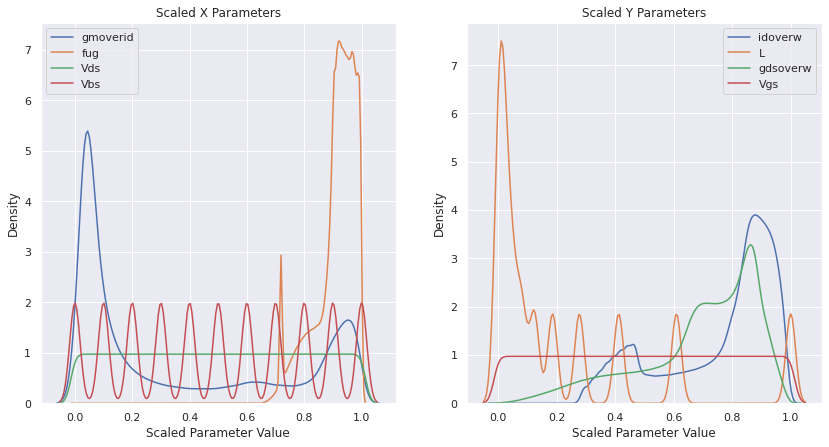

In [10]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,7), nrows=1, ncols=2)

for px in params_x:
    sns.kdeplot(data_scaled[px], ax=ax1, label=px)

for py in params_y:
    sns.kdeplot(data_scaled[py], ax=ax2, label=py)

ax1.set_xlabel("Scaled Parameter Value")
ax1.set_ylabel("Density")
ax1.legend()
ax1.set_title("Scaled X Parameters")
ax2.set_xlabel("Scaled Parameter Value")
ax2.set_ylabel("Density")
ax2.legend()
ax2.set_title("Scaled Y Parameters")

## Training Data Setup

Here the data is converted for use with pytorch.

In [11]:
test_split  = 0.2
batch_size  = 100
num_epochs  = 42
epoch_bar   = master_bar(range(1, num_epochs + 1))
compute_dev = "cuda" if pt.cuda.is_available() else "cpu"

In [12]:
train_x, valid_x, train_y, valid_y = train_test_split( data_scale_x, data_scale_y
                                                     , test_size = test_split
                                                     , shuffle = True
                                                     , random_state = rng_seed
                                                     , )

In [13]:
train_loader = DataLoader( TensorDataset( pt.Tensor(train_x)
                                        , pt.Tensor(train_y))
                         , batch_size )
valid_loader = DataLoader( TensorDataset( pt.Tensor(valid_x)
                                        , pt.Tensor(valid_y))
                         , batch_size )

## The Neural Network

In [14]:
def plasma_net(num_x: int, num_y: int, comp_dev: str) -> pt.nn.Sequential:
    return pt.nn.Sequential( pt.nn.Linear(num_x, 32) , pt.nn.ReLU()
                           , pt.nn.Linear(32, 128)   , pt.nn.ReLU()
                           , pt.nn.Linear(128, 512)  , pt.nn.ReLU()
                           , pt.nn.Linear(512, 128)  , pt.nn.ReLU()
                           , pt.nn.Linear(128, 64)   , pt.nn.ReLU()
                           , pt.nn.Linear(64, 32)    , pt.nn.ReLU() 
                           , pt.nn.Linear(32, num_y) 
                           , ).to(comp_dev)

In [15]:
num_x  = len(params_x)
num_y  = len(params_y)

net = plasma_net(num_x, num_y, compute_dev)

Define Loss functions and optimization algorithm.

In [16]:
loss_mse = pt.nn.MSELoss()
loss_mae = pt.nn.L1Loss()

In [17]:
λ = 0.001
β = (0.5, 0.930)
optimizer = pt.optim.Adam(net.parameters(), lr = λ, betas = β)

In [18]:
def forward_train(X_train, Y_train):
    optimizer.zero_grad()
    out_train = net(X_train)
    mse = loss_mse(out_train, Y_train)
    mse.backward()
    optimizer.step()
    epoch_bar.child.comment = f"Train Batch MSE: {mse:.4}"
    return mse.item()

In [19]:
def forward_valid(X_valid, Y_valid):
    out_valid = net(X_valid)
    mae = loss_mae(out_valid, Y_valid)
    epoch_bar.child.comment = f"Valid Batch MAE: {mae:.4}"
    return mae.item()

In [20]:
def plot_loss(epoch, epochs, bar, train_loss, valid_loss):
    x = range(1, epoch + 1)
    y = np.concatenate((train_loss, valid_loss))
    
    graphs = [[x,train_loss], [x,valid_loss]]
    
    x_margin = 0.2
    y_margin = 0.2
    
    max_y = np.max(y)
    min_y = np.min(y)
    
    x_bounds = [1 - x_margin, epochs + x_margin]
    y_bounds = [ min_y - (y_margin * min_y)
               , max_y + (y_margin * max_y) ]

    bar.update_graph(graphs, x_bounds, y_bounds)

## Training

Go through training loop for `num_epochs` iterations.

In [21]:
train_losses, valid_losses = [], []

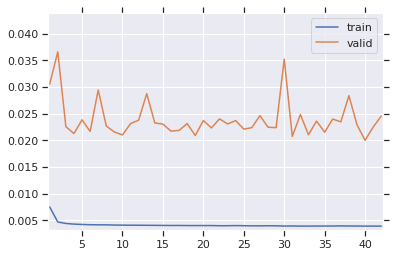

In [22]:
for epoch in epoch_bar:
    net.train()
    train_batch_losses = np.array([ forward_train(x.to(compute_dev), y.to(compute_dev)) 
                                    for (x, y) in progress_bar(train_loader, parent = epoch_bar)])
    train_loss = train_batch_losses.mean()
    train_losses.append(train_loss)
    
    with pt.no_grad():
        net.eval()
        valid_batch_losses = np.array([ forward_valid(x.to(compute_dev), y.to(compute_dev)) 
                                        for (x, y) in progress_bar(valid_loader, parent = epoch_bar)])
        valid_loss = valid_batch_losses.mean()
        valid_losses.append(valid_loss)
        
    if len(valid_losses) > 1 and valid_losses[-2] > valid_loss:
        pt.save(net.state_dict(), f"{model_dir}/model.ckpt")
        
    epoch_bar.main_bar.comment = f"Train MSE: {train_loss:.4}, Valid MAE: {valid_loss:.4}"
    plot_loss(epoch, num_epochs, epoch_bar, train_losses, valid_losses)
    
epoch_bar.write(f"Finished {num_epochs} Epochs, best model checkpoint at {model_dir}/model.ckpt.")

Save the best model as TorchScript.

In [23]:
model = plasma_net(len(params_x), len(params_y), compute_dev)

model.load_state_dict(pt.load(f"{model_dir}/model.ckpt"))

model.cpu().eval()

pt.jit.trace(model, example_inputs = pt.rand(1, len(params_x))).save(f"{model_dir}/model.pt")

## Evaluation

Reload the trained model for a fresh start, as you would in production.

In [24]:
class PlasmaModel:
    def __init__( self, path: str
                , params_x: [str], params_y: [str]
                , trafo_x: [str],  trafo_y: [str] ):
        self.params_x = params_x
        self.params_y = params_y
        
        self.mask_x   = np.array([int(px in trafo_x) for px in self.params_x])
        self.mask_y   = np.array([int(py in trafo_y) for py in self.params_y])
        
        self.scaler_x = jl.load(f"{path}/scale.X")
        self.scaler_y = jl.load(f"{path}/scale.Y")
        self.scale_x  = lambda X: self.scaler_x.transform(X)
        self.scale_y  = lambda Y: self.scaler_y.inverse_transform(Y)
        
        self.trafo_x  = lambda X: (np.log10(np.abs(X), where = (np.abs(X) > 0)) * self.mask_x) + (X * (1 - self.mask_x))
        self.trafo_y  = lambda Y: (np.power(10, Y) * self.mask_y) + (Y * (1 - self.mask_y))
        
        self.model    = pt.jit.load(f"{path}/model.pt").cpu().eval()
    
    def _predict(self, X: np.array) -> np.array:
        with pt.no_grad():
            return pipe( X
                       , self.trafo_x
                       , self.scale_x
                       , np.float32
                       , pt.from_numpy
                       , self.model
                       , pt.Tensor.numpy
                       , self.scale_y
                       , self.trafo_y
                       , )
        
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        Y = pd.DataFrame( self._predict(X[self.params_x].values)
                        , columns = self.params_y ).dropna()
        return Y

In [25]:
mdl = PlasmaModel(model_dir, params_x, params_y, trafo_x, trafo_y)

### Transfer- and Output-Characteristic

Plot the Transfer-Characteristic $I_{d}$ vs. $V_{gs}$ and the Output-Characteristic $I_{d}$ vs $V_{ds}$ for a random $W$ and $L$ from the dataset.

In [26]:
W = np.random.choice(data_raw.W)
L = np.random.choice(data_raw.L)

data_raw["Vgs"] = round(data_raw.Vgs, ndigits = 2)
data_raw["Vds"] = round(data_raw.Vds, ndigits = 2)
data_raw["Vbs"] = round(data_raw.Vbs, ndigits = 2)

traces = data_raw[ (data_raw.W == W) & (data_raw.L == L) 
                 & (data_raw.Vbs == 0.0)  
                 & (data_raw.Vds == (0.9 if device_type == "nmos" else (- 0.9)))
                 ][params_x + params_y].copy().reset_index(drop=True).abs()

tru_x = traces[params_x]
tru_y = traces[params_y]

Make a prediction.

In [27]:
prd_y = mdl.predict(tru_x)

In [28]:
gmoverid_tru = tru_x.gmoverid.values
idoverw_tru  = tru_y.idoverw.values
gdsoverw_tru = tru_y.gdsoverw.values
L_tru        = tru_y.L.values
idoverw_prd  = prd_y.idoverw.values
gdsoverw_prd = prd_y.gdsoverw.values

L_μ      = np.mean(prd_y.L.values)
L_σ      = np.std(prd_y.L.values)
L_hi     = data_raw.L.max()
L_lo     = data_raw.L.min()
L_prd    = np.repeat(L_μ, L_tru.size)

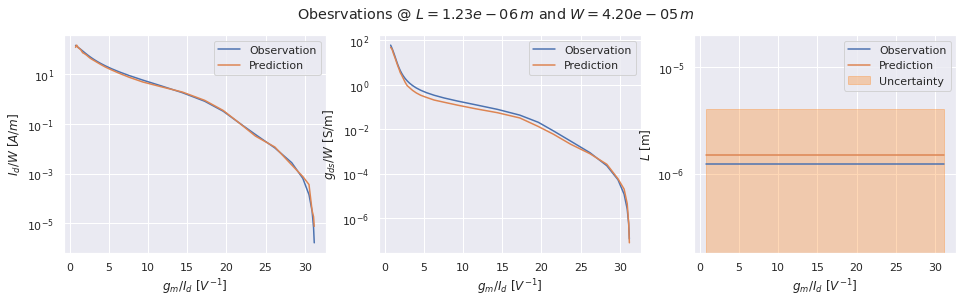

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
fig.suptitle(f"Obesrvations @ $L = {L:.2e}\,m$ and $W = {W:.2e}\,m$")
ax1.plot(gmoverid_tru, idoverw_tru, label = "Observation")
ax1.plot(gmoverid_tru, idoverw_prd, label = "Prediction")
ax1.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax1.set_ylabel("$I_{d} / W ~ [A/m]$")
ax1.set_yscale("log")
ax1.legend()
ax1.grid("on")
ax2.plot(gmoverid_tru, gdsoverw_tru, label = "Observation")
ax2.plot(gmoverid_tru, gdsoverw_prd, label = "Prediction")
ax2.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax2.set_ylabel("$g_{ds} / W$ [S/m]")
ax2.set_yscale("log")
ax2.legend()
ax2.grid("on")
ax3.plot(gmoverid_tru, L_tru, label = "Observation")
ax3.plot(gmoverid_tru, L_prd, label = "Prediction")
ax3.fill_between( gmoverid_tru, (L_prd + (3 * L_σ)), (L_prd - (3 * L_σ))
                , alpha = 0.3, color = "tab:orange", label = "Uncertainty")
ax3.ticklabel_format(axis = 'both', style = 'sci', scilimits = (-2,2))
ax3.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax3.set_ylabel("$L$ [m]")
ax3.set_ylim(min(data_raw.L.values), max(data_raw.L.values))
ax3.set_yscale("log")
ax3.legend()
ax3.grid("on")